# PUC NLP Tarefa 1: Explorando Vetor de Representação de Palavras

In [1]:
# All Import Statements Defined Here
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters

import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /home/vagnersv/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors ou Vetores de Embeddings

Vetores de embeddings são peças fundamentais na construção de pipelines de Processamento de Linguagem Natural utilizados em diversas tarefas, como chatbots, geração de textos, tradução, etc. Desse modo, é importante construir uma intuição de como eles funcionam, seus pontos fortes e suas limitações.

Nessa tarefa, vamos trabalhar com dois tipos de vetores de embeddings: derivados a partir da matriz de co-ocorrência e derivados a partir do método GloVe.

## Parte 1: Vetores de Embeddings Baseados na Matriz de Co-Ocorrência (10 points)

Modelos que utilizam vetores de embeddings normalmente iniciam a partir da seguinte ideia:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Muitas implementações de vetores de embeddings ou word embeddings se baseiam na ideia que palavras com significados semelhantes aparecem em contextos semelhantes. Assim, examinando o contexto das palavras devemos conseguir desenvolver vetores para representá-las. Com essa intuição, abordagens da era pré-deep-learning construiam embeddings a partir de matrizes de co-ocorrência. Na primeira parte dessa tarefa, vamos trabalhar com um desses métodos.

### Co-Ocorrência

A matriz de co-ocorrência conta quantas vezes palavras co-ocorreram no mesmo contexto. Dada uma palavra $w_i$ em um documento, consideramos uma janela de contexto de tamanho fixo $n$ antes e depois de $w_i$. Essa janela conta com as $n$ palavras que precedem $w_i$ e as $n$ palavras seguintes. Nós construímos a matriz quadrada simétrica $M$, que tem como tamanho o número de palavras no vocabulário, e onde a posição $M_{ij}$ conta com o número de vezes que a palavra $w_j$ apareceu na janela de contexto da palavra $w_i$.

**Exemplo: Matriz de Co-Ocorrência com janela fixa de tamanho n = 1**:

Documento 1: "all that glitters is not gold"

Documento 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Nota:** Em NLP, nós normalmente adicionamos os tokens `<START>` e `<END>` para representar o início e fim de sentenças, parágrafos e documentos. No nosso caso, os tokens irão marcar o início e fim de cada documento, que são trechos curtos de texto no dataset que utilizaremos: "`<START>` All that glitters is not gold `<END>`”. Esses tokens são incluídos na matriz de co-ocorrência.

As linhas (ou colunas) da matriz são vetores de representação que podem ser utilizados para representar as palavras do vocabulário. Mas em geral, serão muito grandes - sua dimensão é igual ao número de palavras distintas no vocabulário. Logo, o passo seguinte é realizar redução de dimensionalidade da matriz de co-ocorrência. Faremos uso do algoritmo SVD (Singular Value Decomposition), para selecionar os $k$ principais componentes de nossa representação. Segue uma figura ilustrando o funcionamento do algoritmo.

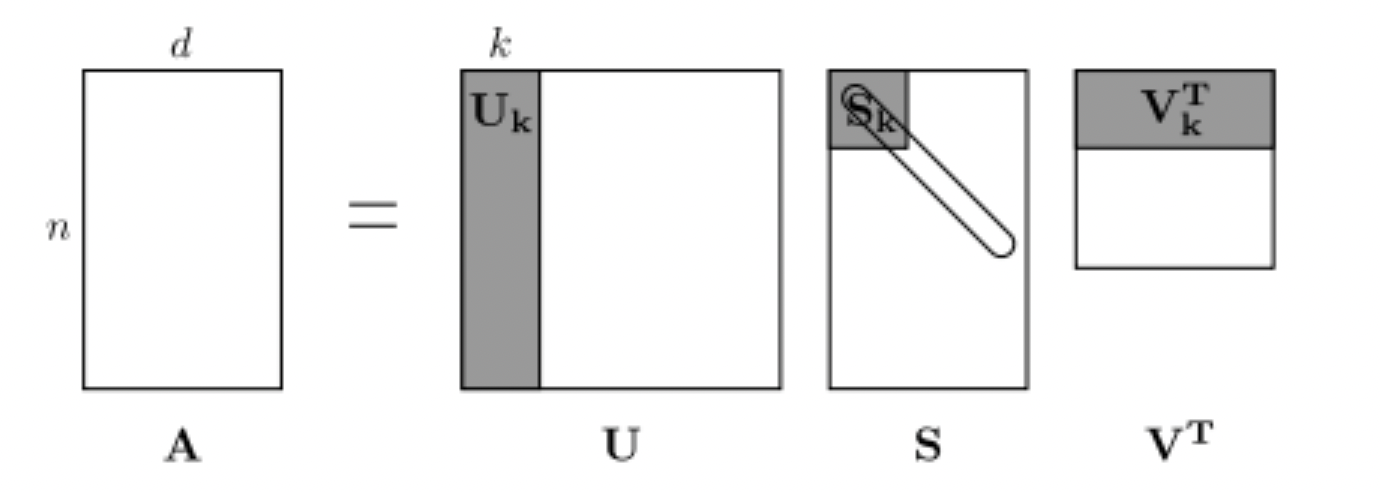

Essa redução de dimensionalidade preserva as relações entre as palavras. Por exemplo, a palavra *hospital* e *médico* continuarão mais próximas que *médico* e *cachorro*.

**Nota:** Em nossa tarefa, iremos estar interessados em extrair apenas os $k$ principais componentes da matriz de ocorrência, e para isso utilizaremos a variação do algoritmo chamada SVD Truncado.

Nessa tarefa vamos utilizar o corpo de texto da Reuters (notícias financeiras e de negócios). O corpo conta com 10,788 documentos (trechos de notícias), com um total de 1.3 milhões de palavras. Esses documentos estão em 90 diferentes categorias, e separados entre conjuntos de treinamento e teste. Nós utilizaremos apenas documentos relacionados a categoria "gold" - notícias sobre ouro, mineração e relacionados.

A função seguinte, além de selecionar essa categoria de documentos, adiciona tokens `<START>` e `<END>` no início e final de cada documento, e transforma todas as letras em minúsculas (caso alguma não esteja). Não é necessário realizar mais nenhum outro tipo de pré-processamento.


In [2]:
def read_corpus(category="gold"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Vamos olhar alguns exemplos de documentos presentes em nosso dataset:

In [3]:
reuters_corpus = read_corpus()
# a função pprint () é útil para imprimir objetos complexos, como listas e dicionários, de forma mais legível
# reuters_corpus[:3] = quantidade de documentos impressos
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'western', 'mining', 'to', 'open', 'new', 'gold', 'mine', 'in', 'australia', 'western',
  'mining', 'corp', 'holdings', 'ltd', '&', 'lt', ';', 'wmng', '.', 's', '>', '(', 'wmc', ')',
  'said', 'it', 'will', 'establish', 'a', 'new', 'joint', 'venture', 'gold', 'mine', 'in', 'the',
  'northern', 'territory', 'at', 'a', 'cost', 'of', 'about', '21', 'mln', 'dlrs', '.', 'the',
  'mine', ',', 'to', 'be', 'known', 'as', 'the', 'goodall', 'project', ',', 'will', 'be', 'owned',
  '60', 'pct', 'by', 'wmc', 'and', '40', 'pct', 'by', 'a', 'local', 'w', '.', 'r', '.', 'grace',
  'and', 'co', '&', 'lt', ';', 'gra', '>', 'unit', '.', 'it', 'is', 'located', '30', 'kms', 'east',
  'of', 'the', 'adelaide', 'river', 'at', 'mt', '.', 'bundey', ',', 'wmc', 'said', 'in', 'a',
  'statement', 'it', 'said', 'the', 'open', '-', 'pit', 'mine', ',', 'with', 'a', 'conventional',
  'leach', 'treatment', 'plant', ',', 'is', 'expected', 'to', 'produce', 'about', '50', ',', '000',
  'ounces', 'of', 'gold'

### Tarefa 1.1: Implementar a função `distinct_words` (2 points)

Escreva um método para, recebendo um corpo de texto e retornar uma lista com todas as palavras do vocabulário ordenadas e sem repetições, e o número total de palavras no vocabulário.

Note que no nosso caso o corpo de texto é formado por uma lista de documentos (lista de listas).

Uma maneira de fazer a tarefa é utilizando `for` loops, mas é mais eficiente utilizar list comprehensions. Como dica [isso](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) pode ser util para transformar uma lista de listas em uma única lista. Se você não é familiar com list comprehensions, esse [link](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html) conta com mais informações.

Reforçando, a lista com todas as palavras do vocabulário a ser retornada, `corpus_words`, deve estar ordenada e não deve conter repetições. Para isso, pode-se transformar a lista em um `set` de modo a remover instâncias duplicadas e utilizar a função `sorted` para ordenação.


In [4]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1

    ### SOLUTION BEGIN

    # criação de uma nova lista de todas as palavras em todos os documentos do corpus.
    # a função set() remove duplicatas da lista e sorted() classifica a lista em ordem alfabética.
    corpus_words = sorted(set([word for document in corpus for word in document]))
    # armazena o tamanho da lista
    n_corpus_words = len(corpus_words)

    ### SOLUTION END

    return corpus_words, n_corpus_words

In [23]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Tarefa 1.2: Implemente o método `compute_co_occurrence_matrix` (3 points)

Escreva um método para construir uma matriz de co-ocorrência com determinado tamanho de janela $n$ (com tamanho padrão 4), considerando $n$ palavras antes e $n$ palavras depois da palavra central. Aqui, utilizaremos `numpy (np)` para representar nossa matriz.



In [5]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """

    # chama a função distinct_words para obter uma lista de palavras distintas e o
    # número total de palavras no corpus
    words, n_words = distinct_words(corpus)
    # inicializa uma matriz quadrada simétrica com zeros e armazenar as
    # contagens de co-ocorrência entre as palavras no corpus.
    M = np.zeros((n_words, n_words))
    # cria um dicionário que mapeia cada palavra para o índice correspondente na
    # matriz de co-ocorrência. O dicionário é usado para indexar as linhas e
    # colunas da matriz de co-ocorrência.
    word2ind = {word: i for i, word in enumerate(words)}

    ### SOLUTION BEGIN

    # percorre cada documento do corpus e cada palavra em um documento
    for document in corpus:
        for i, word in enumerate(document):
          # conta as palavras que aparecem com window_size = 4 antes e depois da palavra.
            for j in range(max(0, i - window_size), min(len(document), i + window_size + 1)):
                if i != j:
                    # atualizada com as contagens de co-ocorrência entre as palavras no corpus.
                    M[word2ind[word], word2ind[document[j]]] += 1

    ### SOLUTION END

    return M, word2ind


# def compute_co_occurrence_matrix(corpus, window_size=4):
#     """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

#         Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
#               number of co-occurring words.

#               For example, if we take the document "START All that glitters is not gold END" with window size of 4,
#               "All" will co-occur with "START", "that", "glitters", "is", and "not".

#         Params:
#             corpus (list of list of strings): corpus of documents
#             window_size (int): size of context window
#         Return:
#             M (numpy matrix of shape (number of corpus words, number of corpus words)):
#                 Co-occurence matrix of word counts.
#                 The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
#             word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
#     """
#     words, num_words = distinct_words(corpus)
#     M = None
#     word2Ind = {}

#     #import numpy as np
#     M = np.zeros((len(words),len(words)))
#     words = list(words)
#     for center_word in words:
#         index = words.index(center_word)
#         word2Ind[center_word]=index
#         for sentence in corpus:
#             for index_of_center_word, word in enumerate(sentence):
#                 if center_word == word:
#                     for i in range(window_size):
#                         if index_of_center_word-i-1 >=0:
#                             l_n = sentence[index_of_center_word-i-1]
#                             M[index,words.index(l_n)]+=1
#                         if index_of_center_word +i+1<len(sentence):
#                             r_n = sentence[index_of_center_word+i+1]
#                             M[index,words.index(r_n)]+=1

#     return M, word2Ind

In [50]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)
print("Correct M:")
print(M_test_ans)
print("Your M: ")
print(M_test)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------
Correct M:
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]]
Your M: 
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]]


### Tarefa 1.3: Implemente o método `reduce_to_k_dim` (1 point)

Construa um método para realizar a redução de dimensionalidade da matriz de co-ocorrência, gerando embeddings finais de dimensão $k$.

Utilizaremos SVD Truncado para extrair os $k$ principais componentes. Sklearn fornece uma implementação eficiente do método. Assim, utilize: [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).


In [6]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    ### SOLUTION BEGIN

    # seleciona os k principais componentes da matriz de co-ocorrência através do
    # parâmetro n_components.
    # o número de iterações é especificado pelo parâmetro n_iters.
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    # o fit é feito para selecionar os k principais componentes da matriz de co-ocorrência.
    svd.fit(M)
    # a menor dimensionalidade é armazenada na variável M_reduced.
    M_reduced = svd.transform(M)

    ### SOLUTION END

    print("\n""Menor dimendionalidade: " "\n", M_reduced)
    print("Done.")
    return M_reduced

In [33]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus_words = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...

Menor dimendionalidade: 
 [[ 6.54802087e-01  7.83221122e-01]
 [ 5.20200324e-01  4.16333634e-16]
 [ 7.05647176e-01 -4.84057274e-01]
 [ 7.05647176e-01  4.84057274e-01]
 [ 1.02780472e+00 -9.43689571e-16]
 [ 6.54802087e-01 -7.83221122e-01]
 [ 3.82258491e-01 -6.56224003e-01]
 [ 3.82258491e-01  6.56224003e-01]
 [ 1.39420808e+00  1.06179274e+00]
 [ 1.39420808e+00 -1.06179274e+00]]
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Tarefa 1.4: Implemente o método `plot_embeddings` (1 point)

Escreva uma função para plotar uma série de vetores em 2D. Utilize o Matplotlib (`plt`).

Para esse exemplo, pode ser útil adaptar [esse código](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/).

In [7]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    ### SOLUTION BEGIN

    # percorre cada palavra e atribui um índice que serve para indexar as linhas
    # e colunas da matriz de co-ocorrência.
    for i,type in enumerate(words):
        # coordenadas x e y da representação da variável M_reduced
        x = M_reduced[i,0]
        y = M_reduced[i,1]
        # plota as coordenadas x e y da representação de M_reduced em um gráfico de dispersão.
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+0.0, y+0.0, type, fontsize=9)
    plt.show()

    ### SOLUTION END

--------------------------------------------------------------------------------
Outputted Plot:


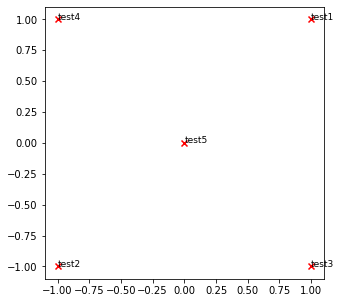

--------------------------------------------------------------------------------


In [8]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

Exemplo de plot a ser obtido:

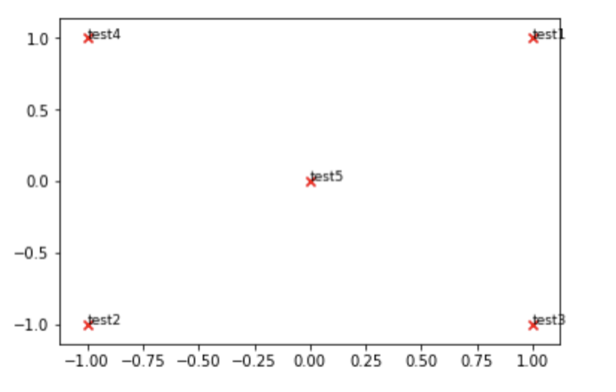

### Tarefa 1.5: Análise dos Embeddings da Matriz de Co-Ocorrência (3 points)

Agora vamos utilizar todo o código que escrevemos para gerar uma matriz de co-ocorrência com contexto de tamanho 4 para o corpo de texto da Reuters. Adicionalmente, vamos utilizar SVD truncado para gerar vetores de embeddings com dimensionalidade 2, e vamos plotá-los para análise.

Note que SVD truncado nos retorna o produto das matrizes U e Sigma, assim iremos normalizar esses vetores antes de plotá-los.

Execute a célula abaixo para produzir o plot. Pode levar alguns segundos para rodar.

Running Truncated SVD over 2830 words...

Menor dimendionalidade: 
 [[ 5.57952292e+01 -1.07849344e+01]
 [ 2.80542506e+01 -7.80947027e+00]
 [ 9.57736936e+01  2.36354362e+01]
 ...
 [ 1.73356980e+01 -1.71118763e+00]
 [ 2.20105936e+00  5.01169162e-02]
 [ 3.56158966e+00  4.35043651e-01]]
Done.
(2830, 2830)
(2830, 2)
(2830,)


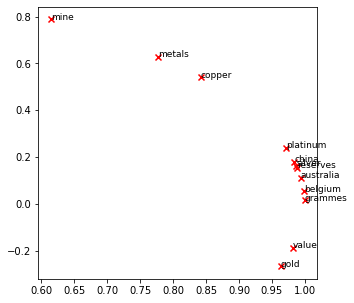

In [9]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)
print(M_co_occurrence.shape)
print(M_reduced_co_occurrence.shape)
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
print(M_lengths.shape)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium',
         'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

**Seu plot deve ser igual a esse. Se não, utilize esse para responder as perguntas seguintes:**

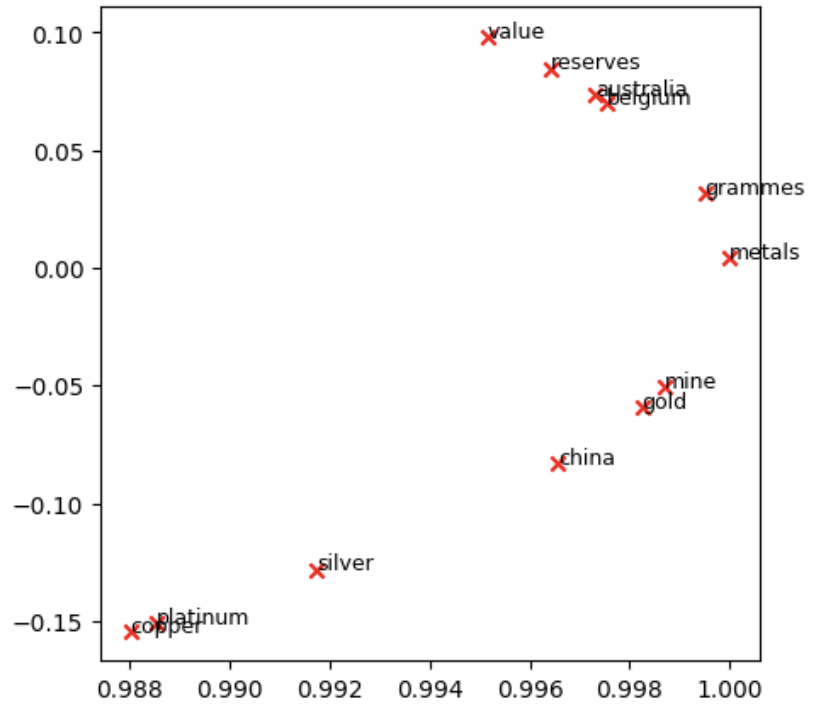

a. Encontre pelo menos dois grupos de palavras que estão agrupadas juntas no espaço bi-dimensional. Dê uma explicação para os agrupamentos observados.

### SOLUTION BEGIN

Não entendi se essa parte é para escrever um código ou é uma resposta dissertativa.

Existe dois grupos de palavras: As que estão em psições positivas e as que estão em posições negativas.

---     
1ª Grupo: copper e platinum. Ambas palavras são metais.       
2º Grupo: australia e belgium. Ambos palavras são países europeus.      
3º Grupo: mine e gold. Em um contexto de mineração de ouro. 
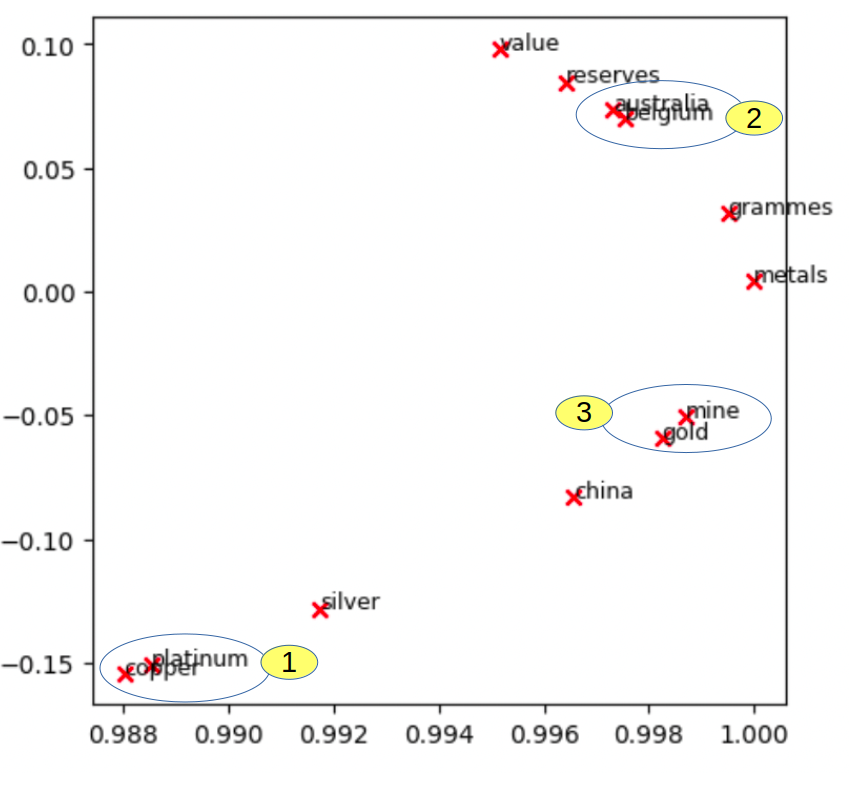

### SOLUTION END

b. Quais palavras não estão agrupadas juntas, mas que você acredita que deveriam estar? Dê pelo menos 2exemplos.

### SOLUTION BEGIN

Existe dois grupos de palavras que deveriam estar agrupadas: 1º grupo se refere a tudo que é relativo a mineração: metais, extração, etc. 2º grupo se refere a nomes países.

--   
1º exemplo: metals com copper e platinum, em um contexto de metais.     
2º exemplo: platinum, gold e silver, num contexto de metais preciosos.        
----------------


### SOLUTION END

## Parte 2: Embeddings baseados em predição - GloVe (5 points)

Recentemente, vetores de embeddings baseados em predição, como Word2Vec e GloVe tem demonstrado desempenho superior a sua contra-parte baseada em co-ocorrência de palavras. Na parte 2 dessa tarefa, utilizaremos vetores de embeddings gerados pelo método GloVe.

Execute as células seguintes para fazer o download dos vetores do GloVe model. Isso pode levar alguns minutos.

In [10]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [11]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


### Reduzindo a dimensionalidade de Word Embeddings

Iremos trabalhar com uma amostra de 10000 vetores de palavras gerados pelo método GloVe. A célula seguinte implementa uma função que seleciona esses vetores e os coloca em uma matriz M.

Na sequência, utilizaremos o método que você implementou para executar SVD truncado e reduzir a dimensionalidade do vetores de embeddings do GloVe para dimensão 2, de modo que possamos plotá-los.

In [12]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [13]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
print(words)
M, word2ind = get_matrix_of_vectors(wv_from_bin, words)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', 'mine']
Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...

Menor dimendionalidade: 
 [[-0.89963347 -0.70346427]
 [-0.75134414  0.23452722]
 [-1.9027554   1.0993137 ]
 ...
 [ 3.6932313  -0.6782904 ]
 [-1.1228975  -1.0754015 ]
 [ 1.9085447  -0.19868596]]
Done.


### Tarefa 2.1: GloVe Análise do gráfico dos word embeddings (2 points)

Rode a célula abaixo para plotar os vetores de embeddings das palavras `['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]`.

10009
(10012, 2)


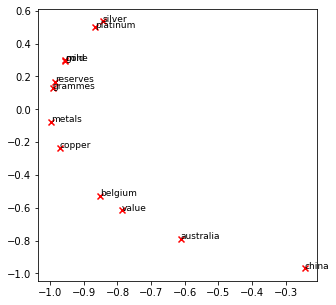

In [14]:
words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

print(word2ind['china'])
print(M_reduced_normalized.shape)
plot_embeddings(M_reduced_normalized, word2ind, words)

**Seu plot deve ser igual a esse. Se não, utilize esse para responder as perguntas seguintes:**

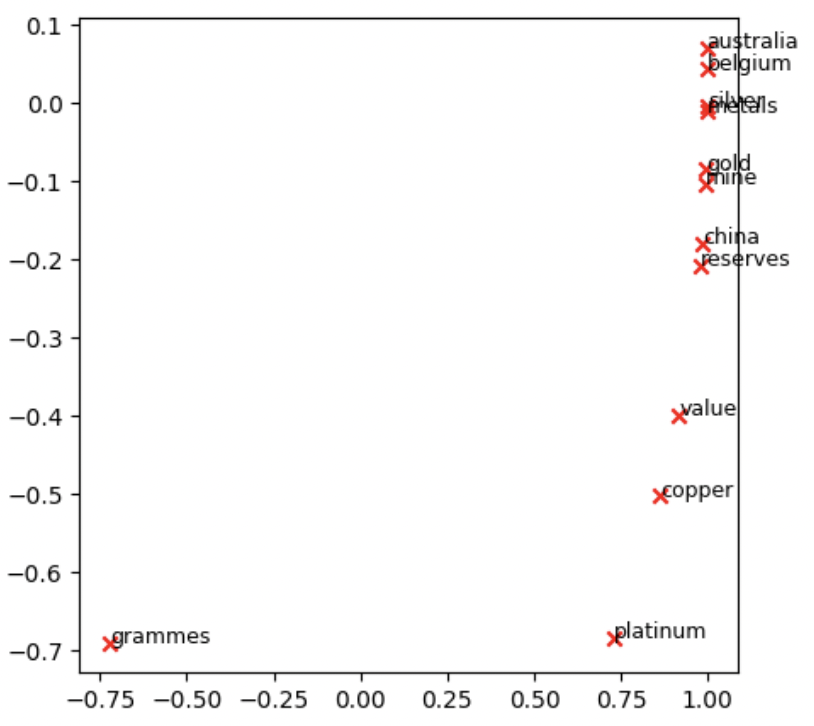

a. De que modo esse plot é diferente do plot gerando anteriormente para matriz de co-ocorrências? E de que modo esse plot é similar?

### SOLUTION BEGIN

Algumas palavras coninuam estar próximas como duplas. porém algumas duplas foram modificadas.     

---
- No eixo Y, o segundo gráfico possui uma amplitude menor (vai até -0.7, já o 1º vai até -0.15). Já no eixo X, o 2º gráfico possui uma amplitude bem maior que o 1º ( -0.75 até 1.00);
- O 2º gráfico aumentou a quantidade de palavras em um mesmo espaço vetorial.
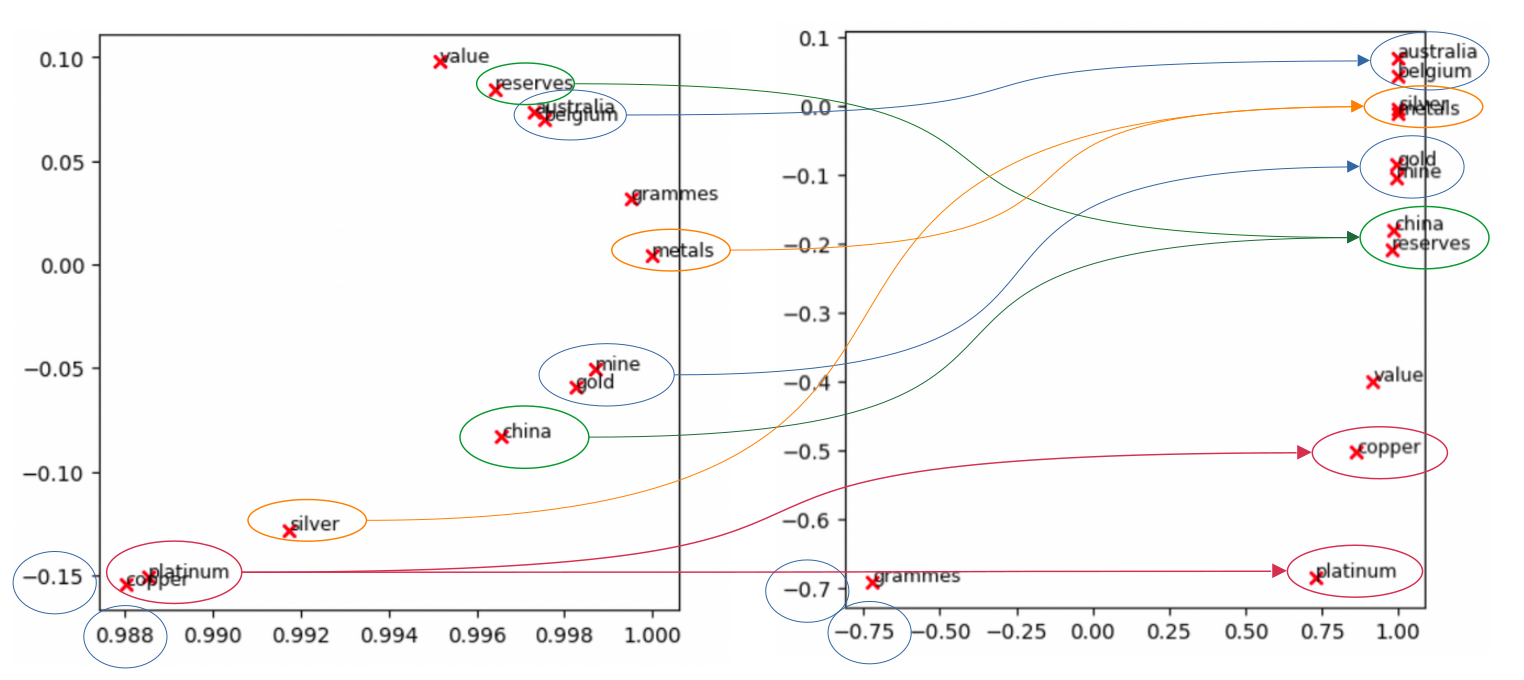

### SOLUTION END

b. Quais as possíveis causas para as diferenças?

### SOLUTION BEGIN

Foram feitas novas associações com as duplas de palavras   

--    
- Por exemplo, uma maior separação entre as palavras copper e platinum, no 2º gráfico, pode ter ocorrido pensando na palavra platinum com o significado de importante (vip) e não de um metal.

### SOLUTION END

## Analogias com Word Vectors

Vetores de embedding mostraram que por vezes conseguem resolver analogias.

Um exemplo de analogia é  "man : grandfather :: woman : x" (lê-se: homem é para avô assim como mulher é para x), qual a resposta certa para x?

Nas tarefas de analogia, utiliza o método `most_similar` implementando pelo GenSim.

Na analogia "man : grandfather :: woman : x" (homem é para avô assim como mulher é para x), o método ficaria com os seguintes argumentos:

`wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']`


In [16]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.644661009311676),
 ('wife', 0.6445354223251343)]


### Question 2.2: Analogias  (1 points)
a. No exemplo anterior, "grandmother"completa a analogia. Mas porque você acha que as próximas palavras mais próximas a completar a analogia foram palavras como "granddaughter", "daughter", or "mother"?

### SOLUTION BEGIN

Porque são os "níveis" mais próximos de grandmother e são femininos.

### SOLUTION END

### Question 2.3: Analogias  (1 points)

b. Crie um exemplo de analogia (ex: man is to woman, as king is to queen):

In [17]:
### SOLUTION BEGIN

print(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man'])[0][0])

### SOLUTION END

queen


### Question 2.4: Pré-conceitos e estereótipos em vetores de embeddings (1 point)

É importante analisarmos os pré-conceitos internalizados pelos nossos vetores de embeddings. Esse tema é especialmente preocupante uma vez que sistemas que utilizam os word embeddings irão tomar decisões levando esses estereótipos em conta.

Na célula abaixo, executamos as seguintes analogias:

Mulher é para profissão assim como homem é para ?

e

Homem é para profissão assim como mulher é para ?

Comente sobre as diferenças nos resultados gerados pelas duas analogias.

In [ ]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.

pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]

[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]


### SOLUTION BEGIN

A comparação 'homem é para' resulta em palavras que definem qualidades profissionais positivas, e também retorna palavras que definem mais experiência. Já as palavras 'mulher é para' retorna palavras que definem menos experiência e profissões culturalmente feminina.

### SOLUTION END